# Цифровая обработка сигналов - Лекция 10
# Тема: Полифазное преобразование Фурье

## Введение

Перед вами обучающий материал по основам **цифровой обработки сигналов** с использованием средств языка программирования Python. Предполагается, что читатель имеет базовые знания из области высшей математики, а также владеет языком Python и хотя бы поверхностно знает различные python-библиотеки - numpy/scipy, matplotlib и другие. 

Для пользователей MATLAB / GNU Octave освоение материала с точки зрения программного кода не составит труда, поскольку основные функции и их атрибуты во многом идентичны и схожи с методами из python-библиотек.


## Усреднение по частоте и по времени

Этот раздел посвящен ещё одной важной теме, в которой разработчики часто путаются при создании приложений цифровой обработки сигналов. Посмотрим, как меняется спектр сигнала при его накоплении по времени и по частоте. Для этого зададим входное гармоническое воздействие:

$$ s(t) = A \cdot cos(\frac{2\pi\cdot t}{T}) \tag{10.1}$$

и добавим к нему аддитивный белый Гауссовский шум (нормальное распределение) `AWGN`:

Функция плотности вероятности:
$$ f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{- \frac{(x-\mu)^2}{2\sigma^2}} \tag{10.2}$$

где $\mu$ - математическое ожидание (среднее значение случайного процесса), а $\sigma$ - среднеквадратическое отклонение.

Таким образом, входной сигнал:

$$ s(t) = A \cdot cos(\frac{2\pi\cdot t}{T}) + N(\mu,\sigma) \tag{10.3}$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

from scipy.fftpack import fft, fftshift
from scipy.signal.windows import kaiser, flattop

FONT_SMALL = 12
FONT_MEDIUM = 14

plt.rc('axes', titlesize=FONT_MEDIUM) 
plt.rc('axes', labelsize=FONT_SMALL)
plt.rc('xtick', labelsize=FONT_SMALL)
plt.rc('ytick', labelsize=FONT_SMALL) 
plt.rc('legend', fontsize=FONT_MEDIUM) 
plt.rc('figure', titlesize=FONT_MEDIUM)

# Matplotlib default params
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
# plt.rcParams['legend.loc'] = 'best'

Для удобства анализа напишем функцию `signals_compare`, цель которой - построение графиков спектра от входного зашумленного сигнала при различных частотах `freq`.

Параметр `l` задает количество усреднений по частоте и времени. 

**Основной цикл:**
На вход системы поступает сигнал длины `n*l`, где `l` - количество усреднений, `n` - длина БПФ.

1. Вычисляем БПФ сигнала длиной `n`,
2. Вычисляем сумму сигналов длиной `n` по `l` разбиений (усреднений), от полученной суммы вычисляем БПФ,
3. Вычисляем `l` БПФ от сигналов длины `n`, а затем полученные результаты усредняем.

Примечания:
- Очевидно, что суммирование серий БПФ должно производиться после взятия операции **модуля**, т.к. при сложении компонент с различной фазой возможна потеря информации (сигнала).
- Параметры частот подбираются специальным образом с целью показать существующие нюансы.
- Длина БПФ во всех случаях задана постоянной и равна N = 512 отсчётов.
- Для удобства анализа рассматриваются нормированные спектры в логарифмическом масштабе.

Таким образом, посмотрим на спектральные составляющие во всех трех случаях:

In [2]:
def freqtime_compare(freq=201, suptitle='', l=1):
    n = 512
    m = n*l

    # Add AWGN
    np.random.seed(42)
    awgn = np.random.normal(0, 9*1e-2, m)

    # Input signal
    t = np.linspace(0, 1, m)

    x = np.cos(2*np.pi*freq*t) + awgn
    x1 = x.reshape(l, n)
    x2 = x.reshape(l, n).sum(0)

    # FFT
    Xx = np.abs(fft(x[:n], n))[:n//2]
    X1 = (np.abs(fft(x1, n))).sum(axis=0)[:n//2]
    X2 = np.abs(fft(x2, n))[:n//2]

    Xxlog = 20*np.log10(Xx / Xx.max())
    X1log = 20*np.log10(X1 / X1.max())
    X2log = 20*np.log10(X2 / X2.max())
    
    fn = np.linspace(0, 0.5, n//2)
    
    # Plot
    plt.figure(figsize=(16, 3), dpi=120)
    plt.suptitle(suptitle)
    plt.subplot(1, 3, 1)
    plt.plot(fn, Xxlog, color='C0', label=f'N={n}')
    plt.ylim([-60, 0])
    plt.legend(loc='upper right')
    
    plt.subplot(1, 3, 2)
    plt.plot(fn, X1log, color='C2', label='Avg (freq)')
    plt.ylim([-60, 0])
    plt.legend(loc='upper right')
    
    plt.subplot(1, 3, 3)
    plt.plot(fn, X2log, color='C3', label='Avg (time)')
    plt.ylim([-60, 0])
    plt.legend(loc='upper right')

#### Число усреднений: 1

При отсутствии усреднения по частоте или времени графики спектров полностью совпадают с модулем БПФ исходного сигнала.

- Левый график: БПФ сигнала длины N
- Средний график: БПФ усредненного по частоте сигнала,
- Правый график: БПФ усредненного по времени сигнала.

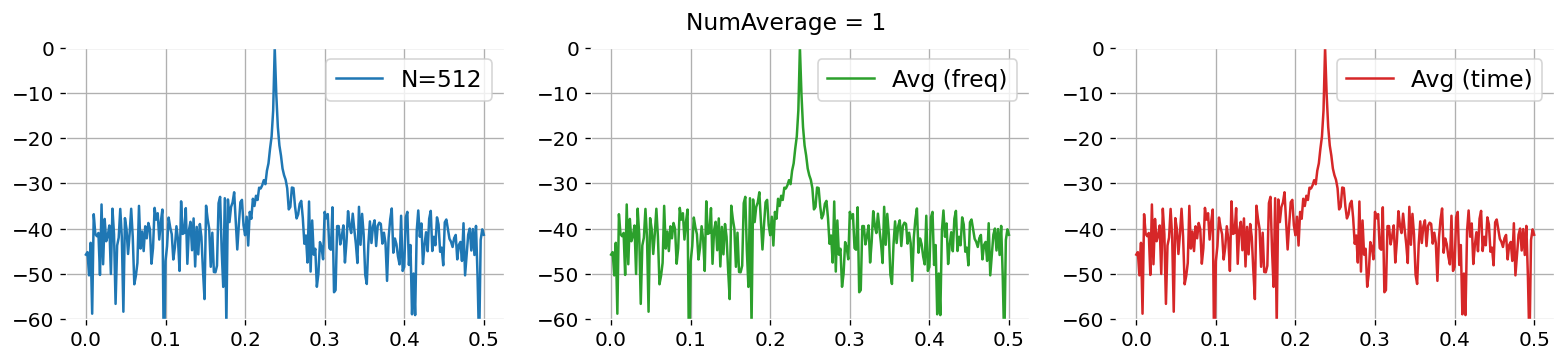

In [3]:
freqtime_compare(freq=121*1, l=1, suptitle='NumAverage = 1')

#### Число усреднений: 15 и 150, частота сигнала кратна числу усреднений

Увеличивая число усреднений, начинают изменяться спектры при накоплении сигналов в частотной и временной областях. В частном случае, когда частота сигнала кратна числу усреднений, имеем следующее:

**Усреднение по частоте**
- Спектр не меняет своего амплитудного значения на частоте сигнала,
- На остальных частотах происходит усреднение некореллированного белого шума
   * Снижается уровень шумовых выбросов,
   * Уровень шума выходит на определенный уровень,
   * Если число усреднений стремится к бесконечности - спектр шума спрямляется в постоянную величину.

**Усреднение по времени**
- Отношение сигнал шум (Signal noise ratio, SNR) увеличивается пропорционально увеличению усреднений,
- Уровень шума уменьшается.

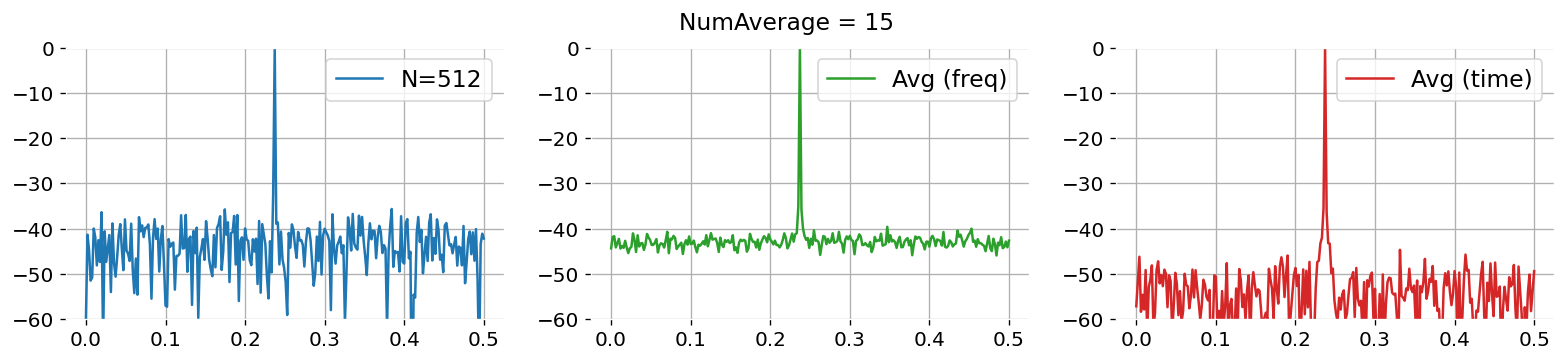

In [4]:
l_avg = 15
freqtime_compare(freq=121*l_avg, l=l_avg, suptitle=f'NumAverage = {l_avg}')

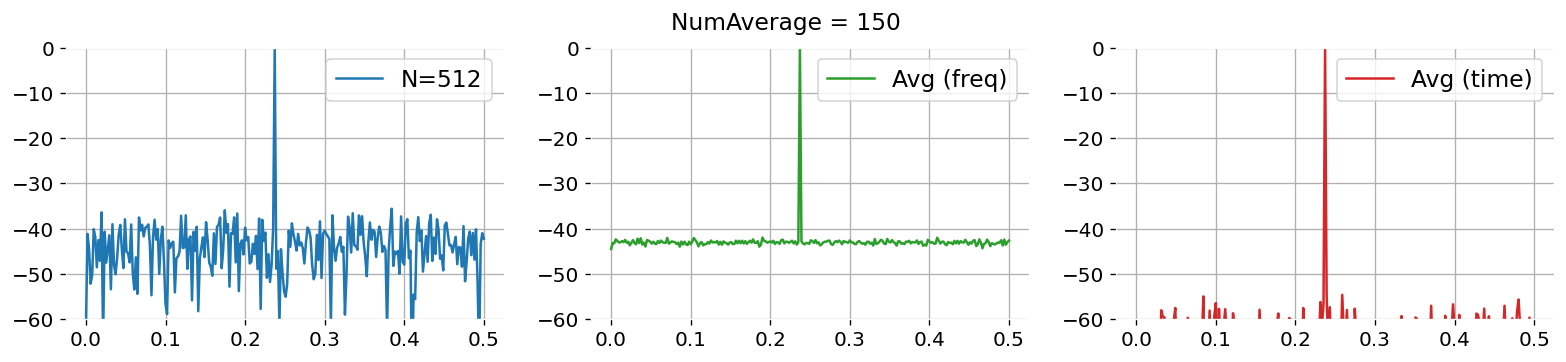

In [5]:
l_avg = 150
freqtime_compare(freq=121*l_avg, l=l_avg, suptitle=f'NumAverage = {l_avg}')

#### Число усреднений: 15, частота сигнала не кратна числу усреднений

Увеличивая число усреднений, начинают изменяться спектры при накоплении сигналов в частотной и временной областях. В случае, когда частота сигнала не кратна длине БПФ, усреднение по времени даёт совершенно противоположные результаты.

**Усреднение по частоте**
- Те же свойства, что и ранее.

**Усреднение по времени**
- Уровень шума существенно возрастает,
- Выбросы шума по-прежнему не сглаживаются.

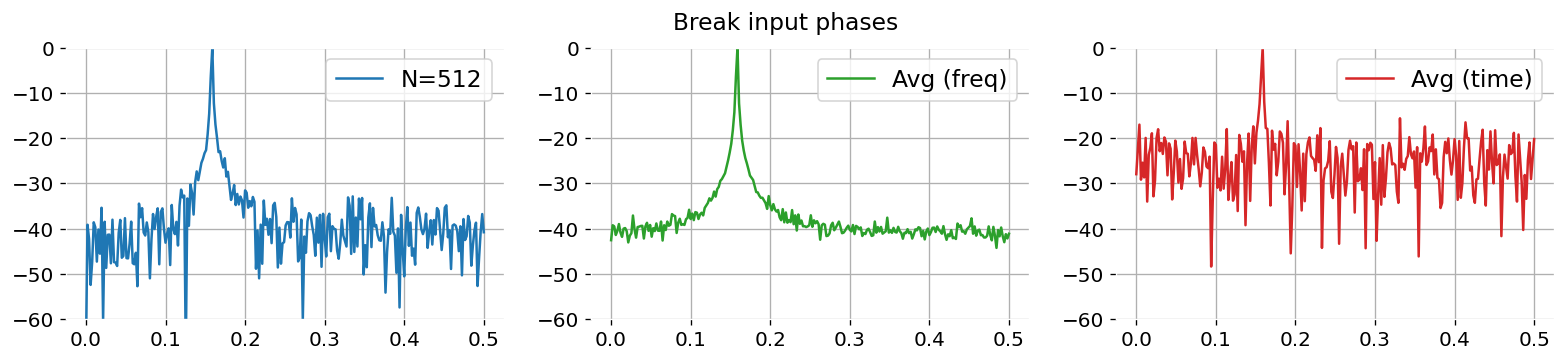

In [6]:
freqtime_compare(freq=1210, l=15, suptitle='Break input phases')

Как видно, *усреднение по времени* приводит к разным результатам в зависимости от кратности частоты сигнала длине БПФ. Для того, чтобы понять различия в результатах, посмотрим на зашумленный сигнал во временной области в обоих случаях.

In [7]:
def time_compare(freq=201, l=1):
    n = 512
    m = n*l

    np.random.seed(42)
    x = np.cos(2*np.pi*freq*np.linspace(0, 1, m)) + np.random.normal(0, 9*1e-1, m)
    y = x.reshape(l, n).sum(axis=0) / l

    plt.figure(figsize=(16, 3), dpi=80)
    plt.plot(y, color='C'+str(l), label=f'Averages = {l}')
    plt.legend(loc='upper left')
    plt.xlim([0, n])
    plt.tight_layout()

**Вариант 1: Начальные фазы усредняемых сигналов совпадают**

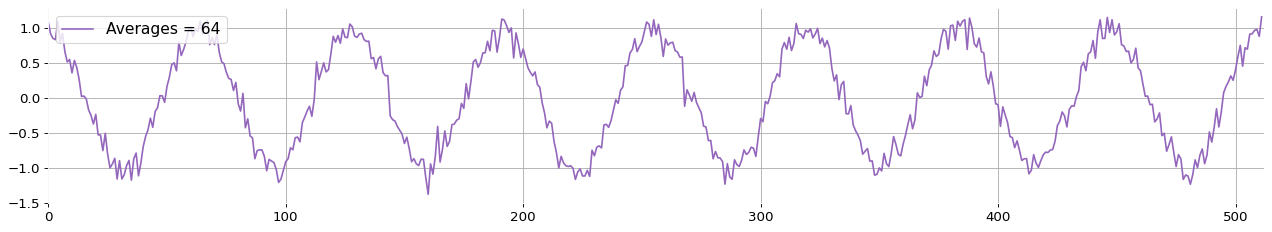

In [8]:
time_compare(freq=512, l=64)

**Вариант 2: Начальные фазы усредняемых сигналов различаются**

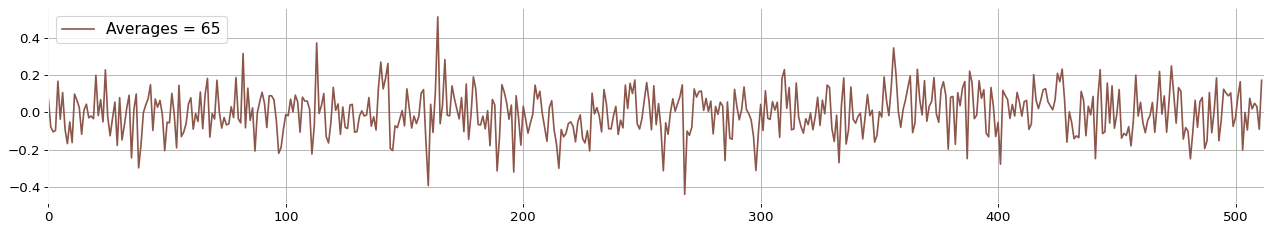

In [9]:
time_compare(freq=512, l=65)

Из представленных выше графиков видно, что если фазы суммируемых компонент совпадают - форма сигнала сохраняется. В противном случае, форма сигнала представляет собой шумоподобный случайный процесс.

Таким образом, пользоваться усреднением **по времени** в общем случае - нельзя. Исключение составляют системы, в которых начальные фазы сигналов, из которых складывается результирующий сигнал, одинаковы. Очевидно, что это частный случай, который практически невозможен на практике в реальных системах цифровой обработки.

Для усреднения модулей спектральных отсчетов **по частоте** зависимости от начальной фазы нет, поэтому результирующий спектр сглаживается при увеличении числа усреднений. На следующем графике изображены амплитудные спектры всех компонент, а также результирующий спектр, равный сумме всех спектральных выборок.

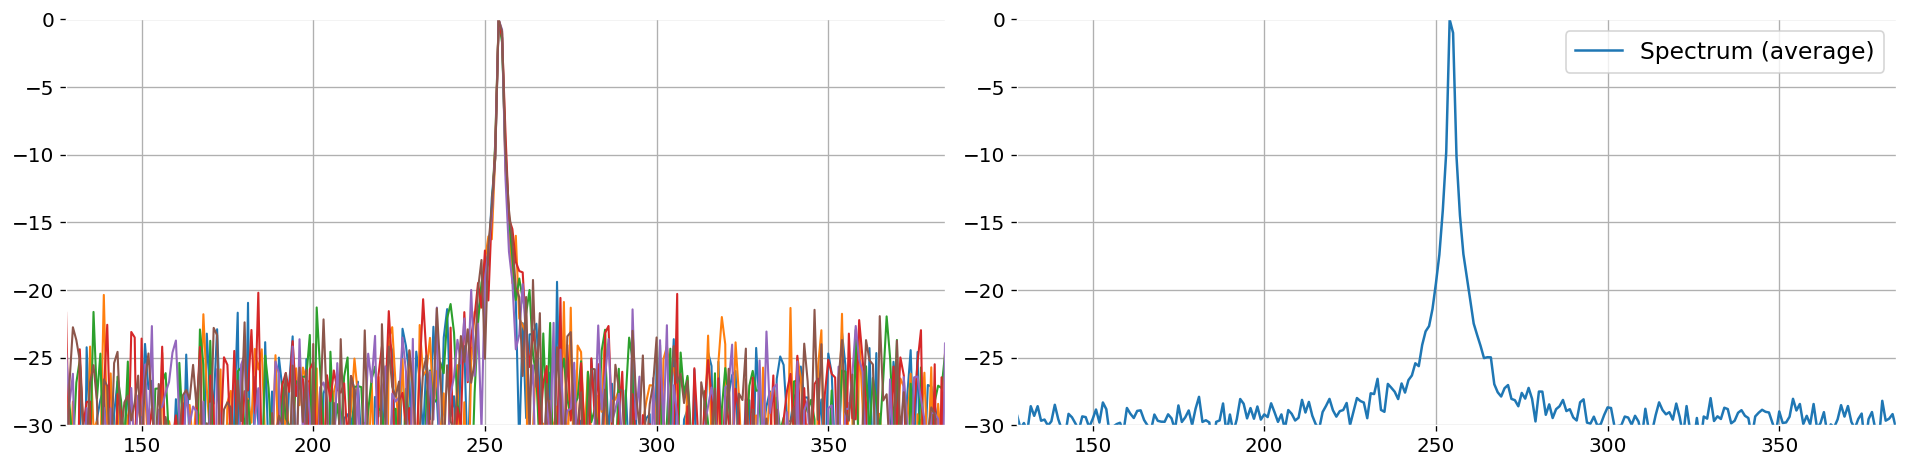

In [10]:
def freq_only(l=32, n=512):
    # Initial Parameters
    m = l*n
    freq = l*(n/4 - 1.5374)

    # Input signal
    np.random.seed(42)
    x = np.cos(2*np.pi*freq*np.linspace(0, 1, m)) + np.random.normal(0, 4*1e-1, m)
    x = x.reshape(l, n)

    y1 = np.abs(fft(x, n))
    y2 = y1.sum(axis=0)

    y1log = 20*np.log10(y1.T / y1.max(axis=1))
    y2log = 20*np.log10(y2 / y2.max())

    plt.figure(figsize=(16, 4), dpi=120)
    plt.subplot(1, 2, 1)
    plt.plot(y1log[:n//2,:6], linewidth=1.25)
    plt.ylim([-30, 0])
    plt.xlim([n//4-n//8, n//4+n//8])
    plt.subplot(1, 2, 2)
    plt.plot(y2log[:n//2], label='Spectrum (average)')
    plt.ylim([-30, 0])
    plt.xlim([n//4-n//8, n//4+n//8])
    plt.legend()
    plt.tight_layout()

freq_only(n=1024)

## Полифазное быстрое преобразование Фурье

В связи с тем, что в некоторых случаях при усреднении сигнала по времени, мы получали выигрыш в отношении сигнал-шум, попробуем использовать это для получения лучших частотных характеристик сигнала. 

Под *полифазным БПФ* понимается следующий алгоритм цифровой обработки сигналов:

- на вход системы поступает `L` сигналов по `N` отсчётов (полная длина выборки `M` = `L*N`)\*
- на выборку длины `M` накладывается оконная функция,
- выборки длиной `N` суммируются по отсчётам,
- от результирующей выборки вычисляется БПФ.

\* - на следующем шаге наложение оконной функции может отсутствовать.

Входной сигнал $x(k), k = 0, ..., M-1$ длительностью $M$ умножается на оконную функцию $w(k), k = 0, ..., M-1$. Затем $x(k)$ сигнал разбивается на $L$ компонент по $N$ отсчётов, которые складываются друг с другом, образуя суммарный сигнал $y(k), k = 0, ..., N-1$. От полученного сигнала вычисляется преобразование Фурье.
___
Посмотрим, как выглядит спектр полифазного БПФ при небольшой длине выборки `N`. Зададим:

- `N` - длина исходного сигнала,
- `M` - длина слагаемых для полифазной схемы,
- `L` - количество разбиений.

Входной сигнал - сумма двух гармонических воздействий с разными частотами `f1` и `f2`. Шумы отсутствуют. Оконная функция не применяется. Построим графики модулей спектров для исходного сигнала и сигнала, полученного в результате разбиений на `L` компонент и дальнейшего суммирования во временной области.

In [11]:
# Number of samples: N
# Number of parts: L
# Total length of signal: M
N, L = 16, 3
M = N*L

# Input signal
t = np.linspace(0, 1, M)
f1, f2 = L, 4*L

x = np.cos(2*np.pi*f1*t) + np.cos(2*np.pi*f2*t)
y = x.reshape(L, N).sum(0)

# FFT - M size
XM = np.abs(fft(x, M))[:M//2]
XM /= XM.max()

# FFT - N size
XN = np.abs(fft(y, N))[:N//2]
XN /= XN.max()

# Interpolated spectrum
XZ = np.zeros(M//2)
#XZ[::L] = XM[::L]
XZ[::L] = XN

На следующем графике представлено два сигнала во временной и частотной областях: 

- исходный сигнал длины `N`,
- суммарный сигнал длины `M`, полученный в результате суммы выборок `L`.

Как видно, спектры сигналов практически идентичны.

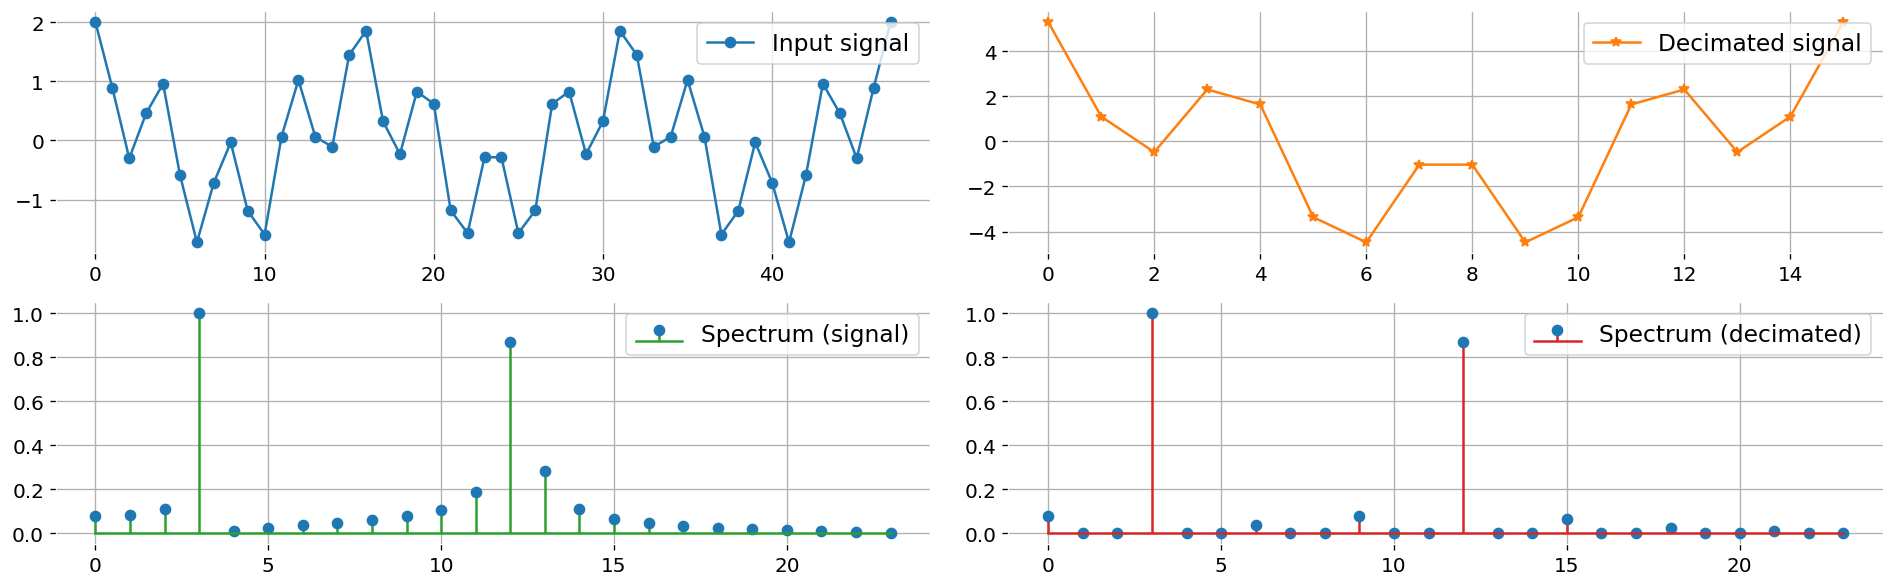

In [12]:
plt.figure(figsize=(16, 5), dpi=120)
plt.subplot(2, 2, 1)
plt.plot(x, '-o', markersize=6, color='C0', label='Input signal')
plt.legend(loc='upper right')
plt.subplot(2, 2, 2)
plt.plot(y, '-*', markersize=6, color='C1', label='Decimated signal')
plt.legend(loc='upper right')
plt.subplot(2, 2, 3)
plt.stem(XM, use_line_collection=True, linefmt='C2', basefmt='C2', label='Spectrum (signal)')
plt.legend(loc='upper right')
plt.subplot(2, 2, 4)
plt.stem(XZ, use_line_collection=True, linefmt='C3', basefmt='C3', label='Spectrum (decimated)')
plt.legend(loc='upper right')
plt.tight_layout()

Спектр полифазного БПФ полностью эквивалентен (в пределах погрешностей вычислений) спектру БПФ всей последовательности, децимированной по количеству выборок, реализующих полифазный алгоритм. Иными словами, спектр полифазного БПФ равен прореженному спектру исходной последовательности. Следующий рисунок отображает это утверждение.

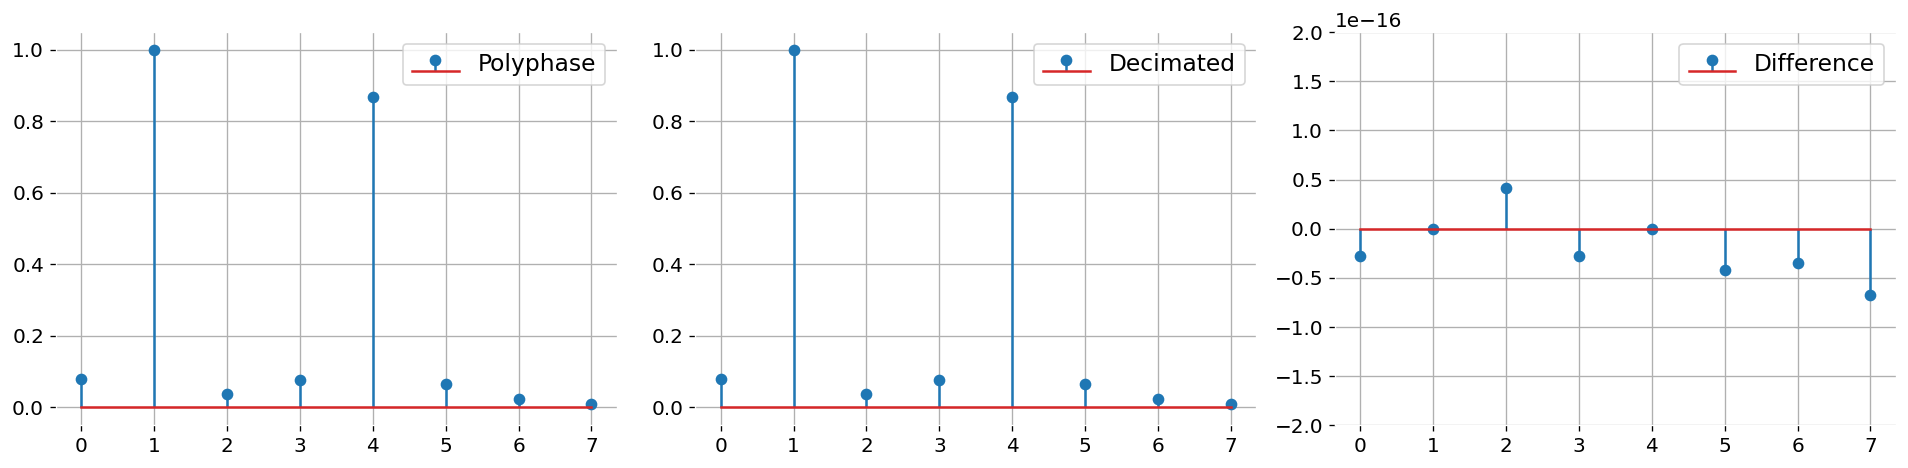

In [13]:
plt.figure(figsize=(16, 4), dpi=120)
plt.subplot(1, 3, 1)
plt.stem(XN, 
         use_line_collection=True, 
         label='Polyphase'
        )
plt.legend(loc='upper right')

plt.subplot(1, 3, 2)
plt.stem(XM[::L], 
         use_line_collection=True, 
         label='Decimated'
        )
plt.legend(loc='upper right')

plt.subplot(1, 3, 3)
plt.stem(XN-XM[::L], 
         use_line_collection=True, 
         label='Difference'
        )

plt.ylim(1e-16*np.array([-2, 2]))
plt.legend(loc='upper right')
plt.tight_layout()

## Потеря сигнала

Факт идентичности спектров может навести на мысль использовать БПФ меньшей длины. В частности, это актуально для высоконагруженных приложений, где критично время вычисления или не достаточно ресурсов для вычисления БПФ больших длин. Но так ли это на самом деле и всегда ли применима эта схема?

Посмотрим, что будет, если частоту одного из сигналов сдвинуть на 1 отсчёт (в понятиях спектральных компонент БПФ). В этом случае частота становится не кратной длине разбиений.

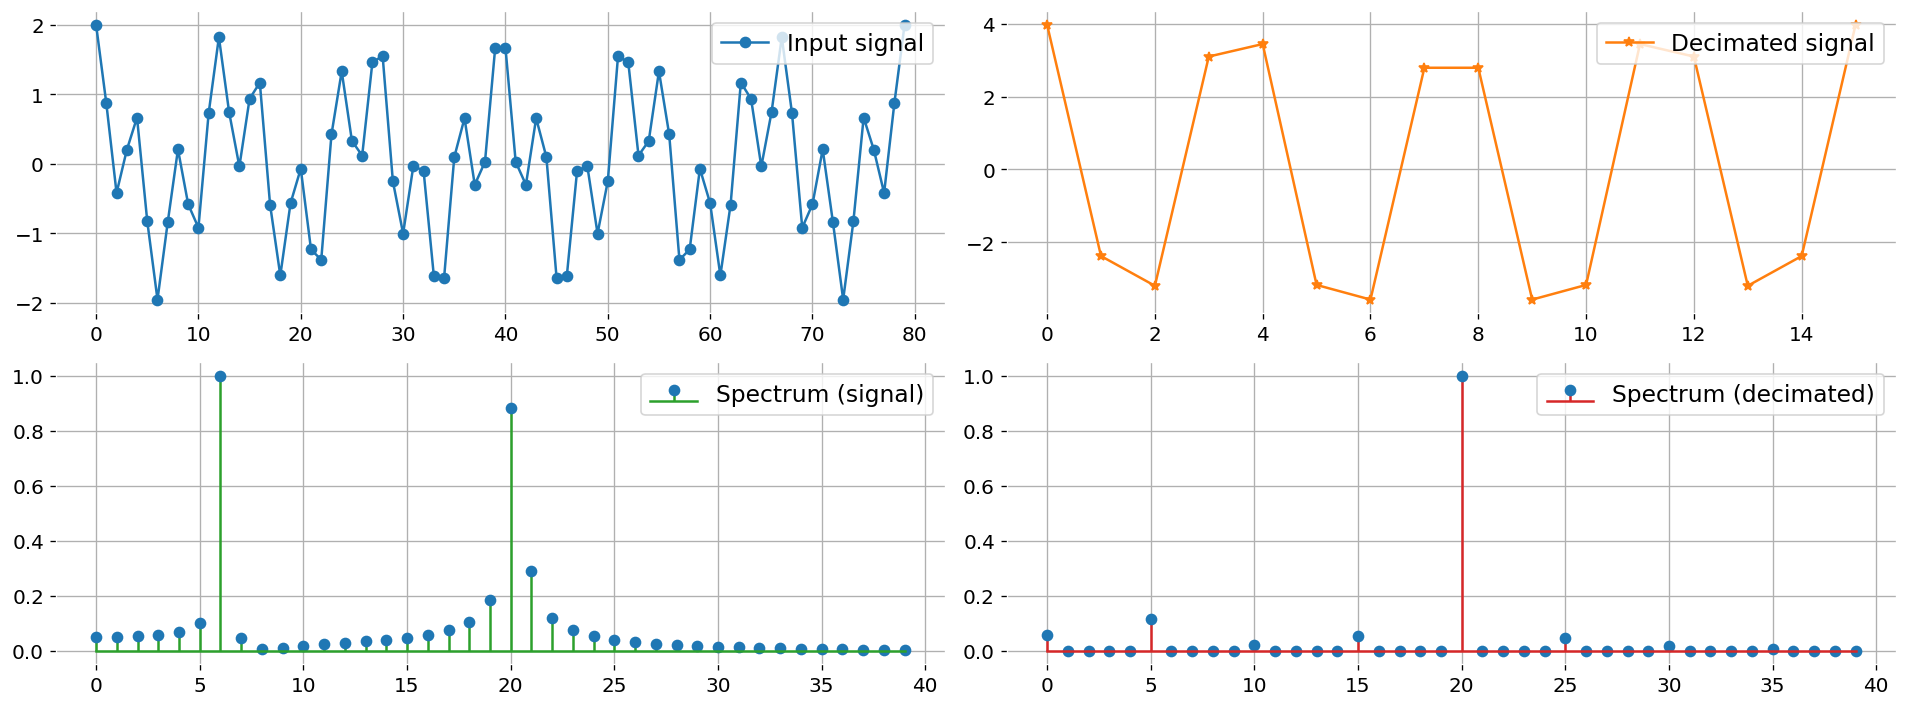

In [14]:
# Input signal
N, L = 16, 5
M = N*L

t = np.linspace(0, 1, M)
f1, f2 = L+1, 4*L

x = np.cos(2*np.pi*f1*t) + np.cos(2*np.pi*f2*t)
y = x.reshape(L, N).sum(0)

# FFT 
XM = np.abs(fft(x, M))[:M//2]
XN = np.abs(fft(y, N))[:N//2]
XM /= XM.max()
XN /= XN.max()

# Interpolated spectrum
XZ = np.zeros(M//2)
#XZ[::L] = XM[::L]
XZ[::L] = XN

plt.figure(figsize=(16, 6), dpi=120)
plt.subplot(2, 2, 1)
plt.plot(x, '-o', markersize=6, color='C0', label='Input signal')
plt.legend(loc='upper right')
plt.subplot(2, 2, 2)
plt.plot(y, '-*', markersize=6, color='C1', label='Decimated signal')
plt.legend(loc='upper right')
plt.subplot(2, 2, 3)
plt.stem(XM, use_line_collection=True, linefmt='C2', basefmt='C2', label='Spectrum (signal)')
plt.legend(loc='upper right')
plt.subplot(2, 2, 4)
plt.stem(XZ, use_line_collection=True, linefmt='C3', basefmt='C3', label='Spectrum (decimated)')
plt.legend(loc='upper right')
plt.tight_layout()

Как видно из следующего графика, сигнал на частоте `f1` пропал из спектра полифазного БПФ. Известно, что спектр полифазного БПФ равен децимированному спектру исходного сигнала. Следовательно, в результате децимации по частоте эта спектральная компонента не вошла в рассматриваемую выборку (отсчеты берутся кратно `L`).

Ранее мы выяснили, что при несовпадении начальных фаз выборок, формирующих суммарный сигнал, характеристики такого сигнала ухудшаются. Форма сигнала меняется, а уровень спектральной компоненты существенно уменьшается в связи с тем, что амплитуда суммарного сигнала падает.

В качестве доказательства построим графики сигналов на частотах `f1` и `f2` во временной области до суммирования и после.

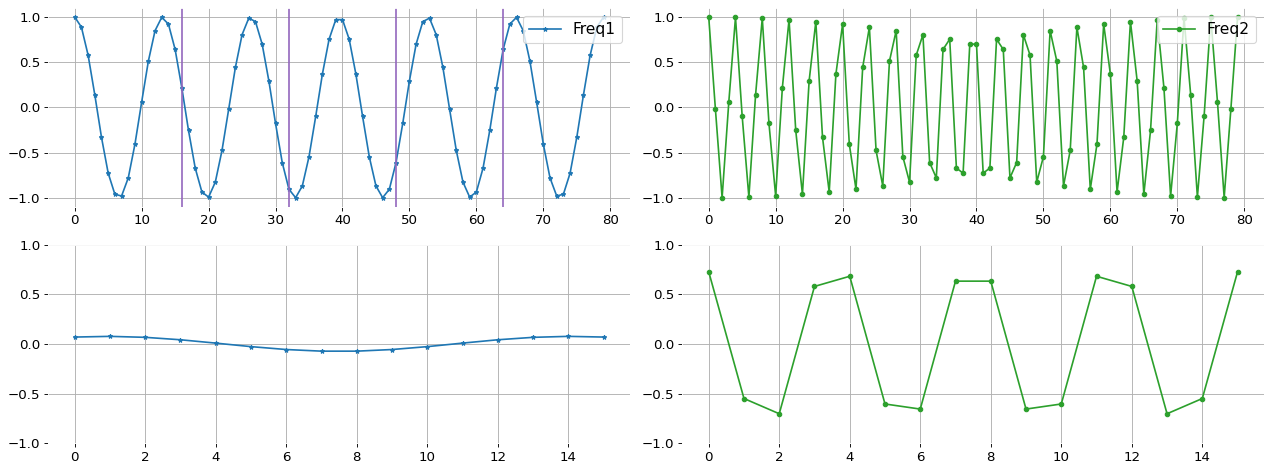

In [15]:
plt.figure(figsize=(16, 6), dpi=80)
plt.subplot(2, 2, 1)
plt.plot(np.cos(2*np.pi*f1*t), '-*', markersize=4, color='C0', label='Freq1')
for i in range(1, L):
    plt.axvline(i*N, color='C4', linewidth=1.5)
plt.legend(loc='upper right')

plt.subplot(2, 2, 2)
plt.plot(np.cos(2*np.pi*f2*t), '-o', markersize=4, color='C2', label='Freq2')
plt.legend(loc='upper right')

plt.subplot(2, 2, 3)
plt.plot(np.cos(2*np.pi*f1*t).reshape(L, N).sum(0) / L, '-*', markersize=4, color='C0', label='Freq1')
plt.ylim([-1, 1])

plt.subplot(2, 2, 4)
plt.plot(np.cos(2*np.pi*f2*t).reshape(L, N).sum(0) / L, '-o', markersize=4, color='C2', label='Freq2')
plt.ylim([-1, 1])
plt.tight_layout()

## Оконные функции

Ранее мы выяснили, что спектр полифазного сигнала (полифазного БПФ) эквивалентен разреженному спектру всей последовательности (коэффициент децимации равен `L`). При использовании сигналов, частота которых не кратна `L` в результирующем спектре теряется информация. Дабы избежать потери сигнала, попробуем использовать оконную функцию, которая "размазывает" спектр сигнала по частоте. 

Для этих целей попробуем применить оконную функцию с плоской вершиной `flattop window`.

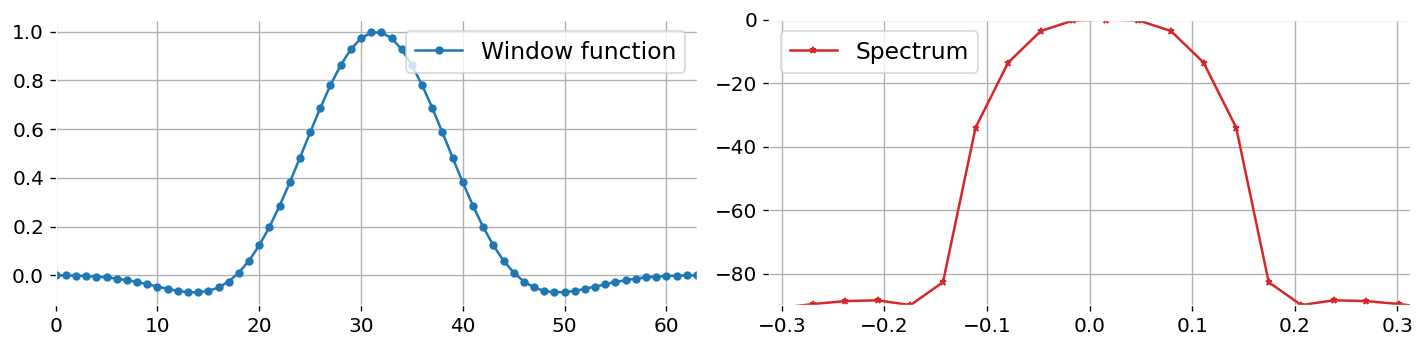

In [16]:
# Window function: flattop
Nfft = 64

win_freq = np.linspace(-1, 1, Nfft)
win_flat = flattop(Nfft) # from scipy

win_ffts = fftshift(np.abs(fft(win_flat, Nfft)))
win_ffts = win_ffts / np.amax(win_ffts, axis=0) + np.nextafter(0,1)
win_logs = 20*np.log10(win_ffts)

# Plot results
plt.figure(figsize=(12, 3), dpi=120)
plt.subplot(1, 2, 1)
plt.plot(win_flat, '-o', markersize=4, label='Window function')
plt.legend(loc='upper right')
plt.xlim([0, Nfft-1])

plt.subplot(1, 2, 2)
plt.plot(win_freq, win_logs,'-*', markersize=4, color='C3', label='Spectrum')
plt.xlim([-20/Nfft, 20/Nfft])
plt.ylim([-90, 0])
plt.legend(loc='upper left')
plt.tight_layout()

Умножим полный сигнал длительностью `N` на оконную функцию. Затем разобьём этот сигнал на `L` выборок по `N` отсчётов. От суммы полученных выборок вычислим БПФ длиной `M`.

После умножения исходного сигнала на оконную функцию результирующие спектральные компоненты расширяются. В идеале необходимо подобрать такое "расширение", чтобы не потерялся ни один спектральный отсчёт. 

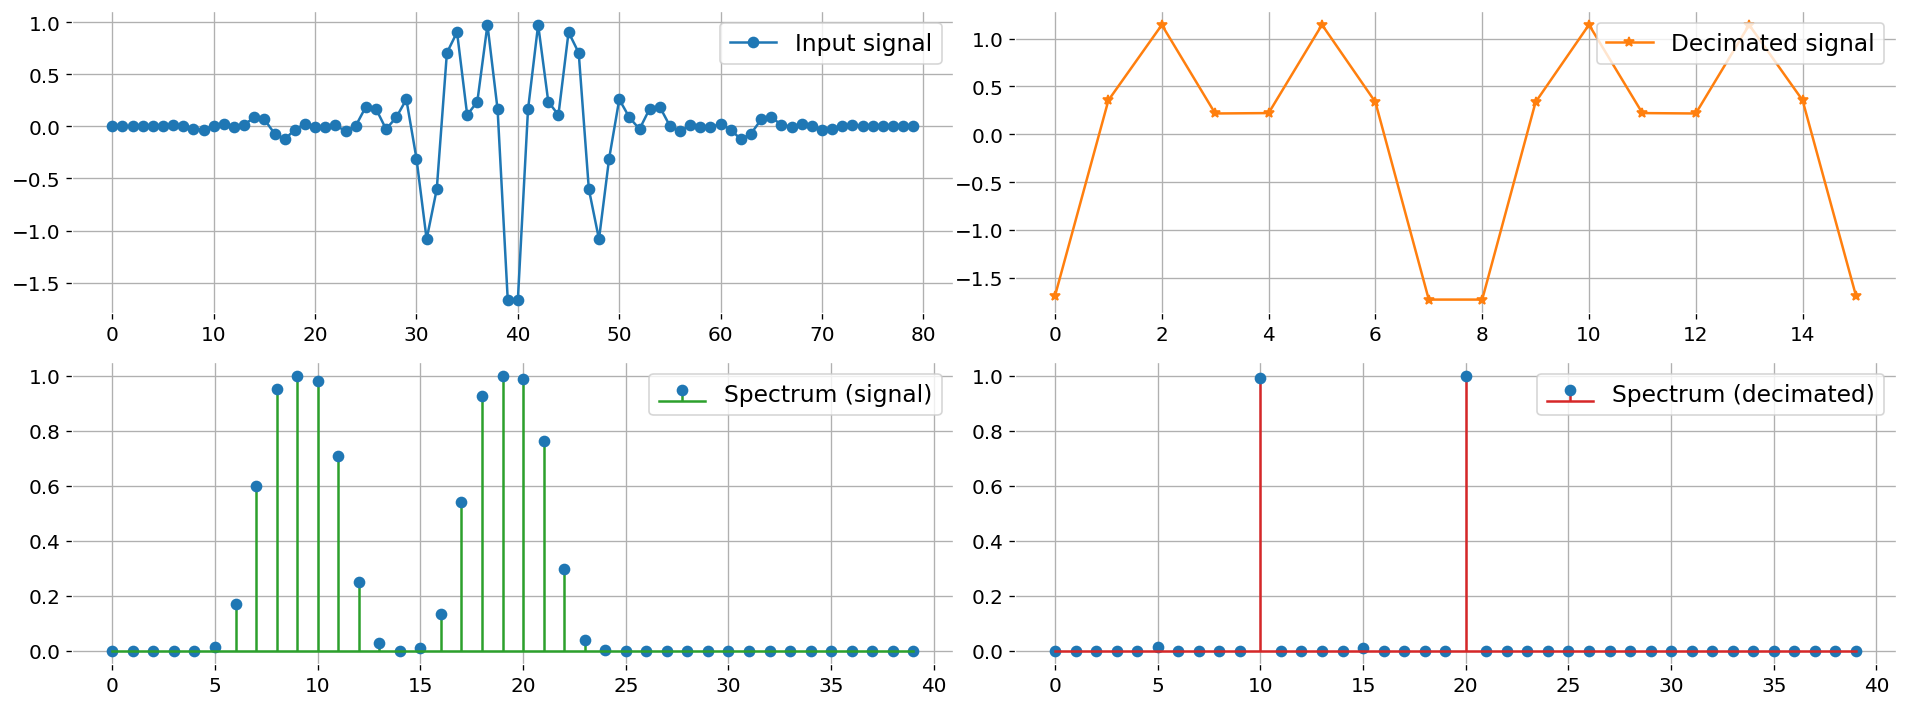

In [17]:
N, L = 16, 5
M = N*L

# Input signal + Window Function
#wn = kaiser(M, beta=13)
wn = flattop(M)

t = np.linspace(0, 1, M)
f1, f2 = 2*L-1, 4*L-1
x = np.cos(2*np.pi*f1*t) + np.cos(2*np.pi*f2*t)
x *= wn
y = x.reshape(L, N).sum(0)

# FFT - M size
XM = np.abs(fft(x, M))[:M//2]
XM /= XM.max()

# FFT - N size
XN = np.abs(fft(y, N))[:N//2]
XN /= XN.max()

# Interpolated spectrum
XZ = np.zeros(M//2)
#XZ[::L] = XM[::L]
XZ[::L] = XN

plt.figure(figsize=(16, 6), dpi=120)
plt.subplot(2, 2, 1)
plt.plot(x, '-o', markersize=6, color='C0', label='Input signal')
plt.legend(loc='upper right')
plt.subplot(2, 2, 2)
plt.plot(y, '-*', markersize=6, color='C1', label='Decimated signal')
plt.legend(loc='upper right')
plt.subplot(2, 2, 3)
plt.stem(XM, use_line_collection=True, linefmt='C2', basefmt='C2', label='Spectrum (signal)')
plt.legend(loc='upper right')
plt.subplot(2, 2, 4)
plt.stem(XZ, use_line_collection=True, linefmt='C3', basefmt='C3', label='Spectrum (decimated)')
plt.legend(loc='upper right')
plt.tight_layout()

Как видно, применение оконной функции позволило не потерять информацию по частотам `f1` и `f2`, несмотря на то, что обе не кратны количеству разбиений `L`.

## Примеры полифазного БПФ

Ниже приведены различные комбинации выполнения усреднения по времени с последующим вычислением БПФ. Рассмотрим основные особенности.

In [18]:
def calculate_ffts(f1, f2, n, step, beta=7, use_win=False):
    # Time vector
    m = n*step
    t = np.linspace(0, 1, m)
    # Add AWGN
    np.random.seed(42)
    awgn = np.random.normal(0, 2*1e-3, m)
    # Signal, window function, polyphase FFTs
    wn = kaiser(m, beta=beta)
    x = np.cos(2*np.pi*f1*t) + np.cos(2*np.pi*f2*t) + awgn
    
    y = (x * wn).reshape(step, n).sum(0)

    if use_win:
        x *= wn

    # FFT - M size
    XW = np.abs(fft(x, n))[:n//2]
    XW /= XW.max()
    # FFT - N size
    XN = np.abs(fft(y, n))[:n//2]
    XN /= XN.max()
    # Log spectrum
    XWlog = 20*np.log10(XW / XW.max())
    XNlog = 20*np.log10(XN / XN.max())
    
    return XWlog, XNlog

nfft, step = 2048, 4
Xw = np.zeros([6, nfft//2])
Xn = np.zeros([6, nfft//2])

Xw[0], Xn[0] = calculate_ffts(182, 312, nfft, step, use_win=True)
Xw[1], Xn[1] = calculate_ffts(184, 312, nfft, step)
Xw[2], Xn[2] = calculate_ffts(184, 312, nfft, step, beta=150)
Xw[3], Xn[3] = calculate_ffts(184, 192, nfft, step, beta=300)
Xw[4], Xn[4] = calculate_ffts(184, 200, nfft, step, beta=1)
Xw[5], Xn[5] = calculate_ffts(185, 191, nfft, step)

xs_titles = ['Loss signal at 1st freq', 
             'Determine both freqs',
             'Change window function',
             'Bad window function',
             'No window function',
             'Improve freq resolution',
            ]

Будем рассматривать сумму двух гармонических сигналов с добавлением белого шума. Перед вычислением полифазного БПФ всегда накладывается оконная функция Кайзера с переменным параметром `beta`, но для сравнения наложение окна на исходный сигнал может отсутствовать. Для удобства построения графиков написана специальная функция, принимающая на вход следующие параметры:

- `f1`, `f2` - частоты гармонических колебаний,
- `nfft` - длина БПФ,
- `step` - количество усреднений (эквивалентно параметру `l`),
- `use_win` - использование оконной функции Кайзера (True/False)
- `beta` - параметр оконной функции Кайзера.

Параметры: длина БПФ `nfft = 2048` и количество усреднений `step = 4` не меняются.

Результаты:
1. `f1 = 182`, `f2 = 312` - потеря сигнала на первой частоте (некратной разбиению) в связи с неправильным выбором оконной функции (спектр не расширяется, начальные фазы суммируемых компонент - различны),
2. `f1 = 184`, `f2 = 312` - улучшение отношения сигнал-шум в связи с точным попаданием частот (начальные фазы суммируемых компонент одинаковы, искажение сигнала не происходит, уровень не падает),
3. `f1 = 184`, `f2 = 312`, `beta=150` - при увеличении параметра `beta` происходит расширение спектральных компонент, что может привести к неразличимости сигналов (см. далее),
4. `f1 = 184`, `f2 = 192`, `beta=300` - из-за неверного выбора параметра оконной функции произошло наложение двух стоящих рядом гармоник. В этом случае при полифазной обработке невозможно различить два сигнала.
5. `f1 = 184`, `f2 = 192`, `beta=1` - отсутствие оконной фильтрации ожидаемо приводит к совпадению спектра исходного сигнала и спектра сигнала при полифазной обработке.
6. `f1 = 185`, `f2 = 191` - сигналы сдвинуты ещё ближе друг к другу. В случае полифазной обработки с правильно выбранным параметром оконной функции возможно получить различимость двух гармоник, однако в исходном спектре эти гармоники сливаются в одну.

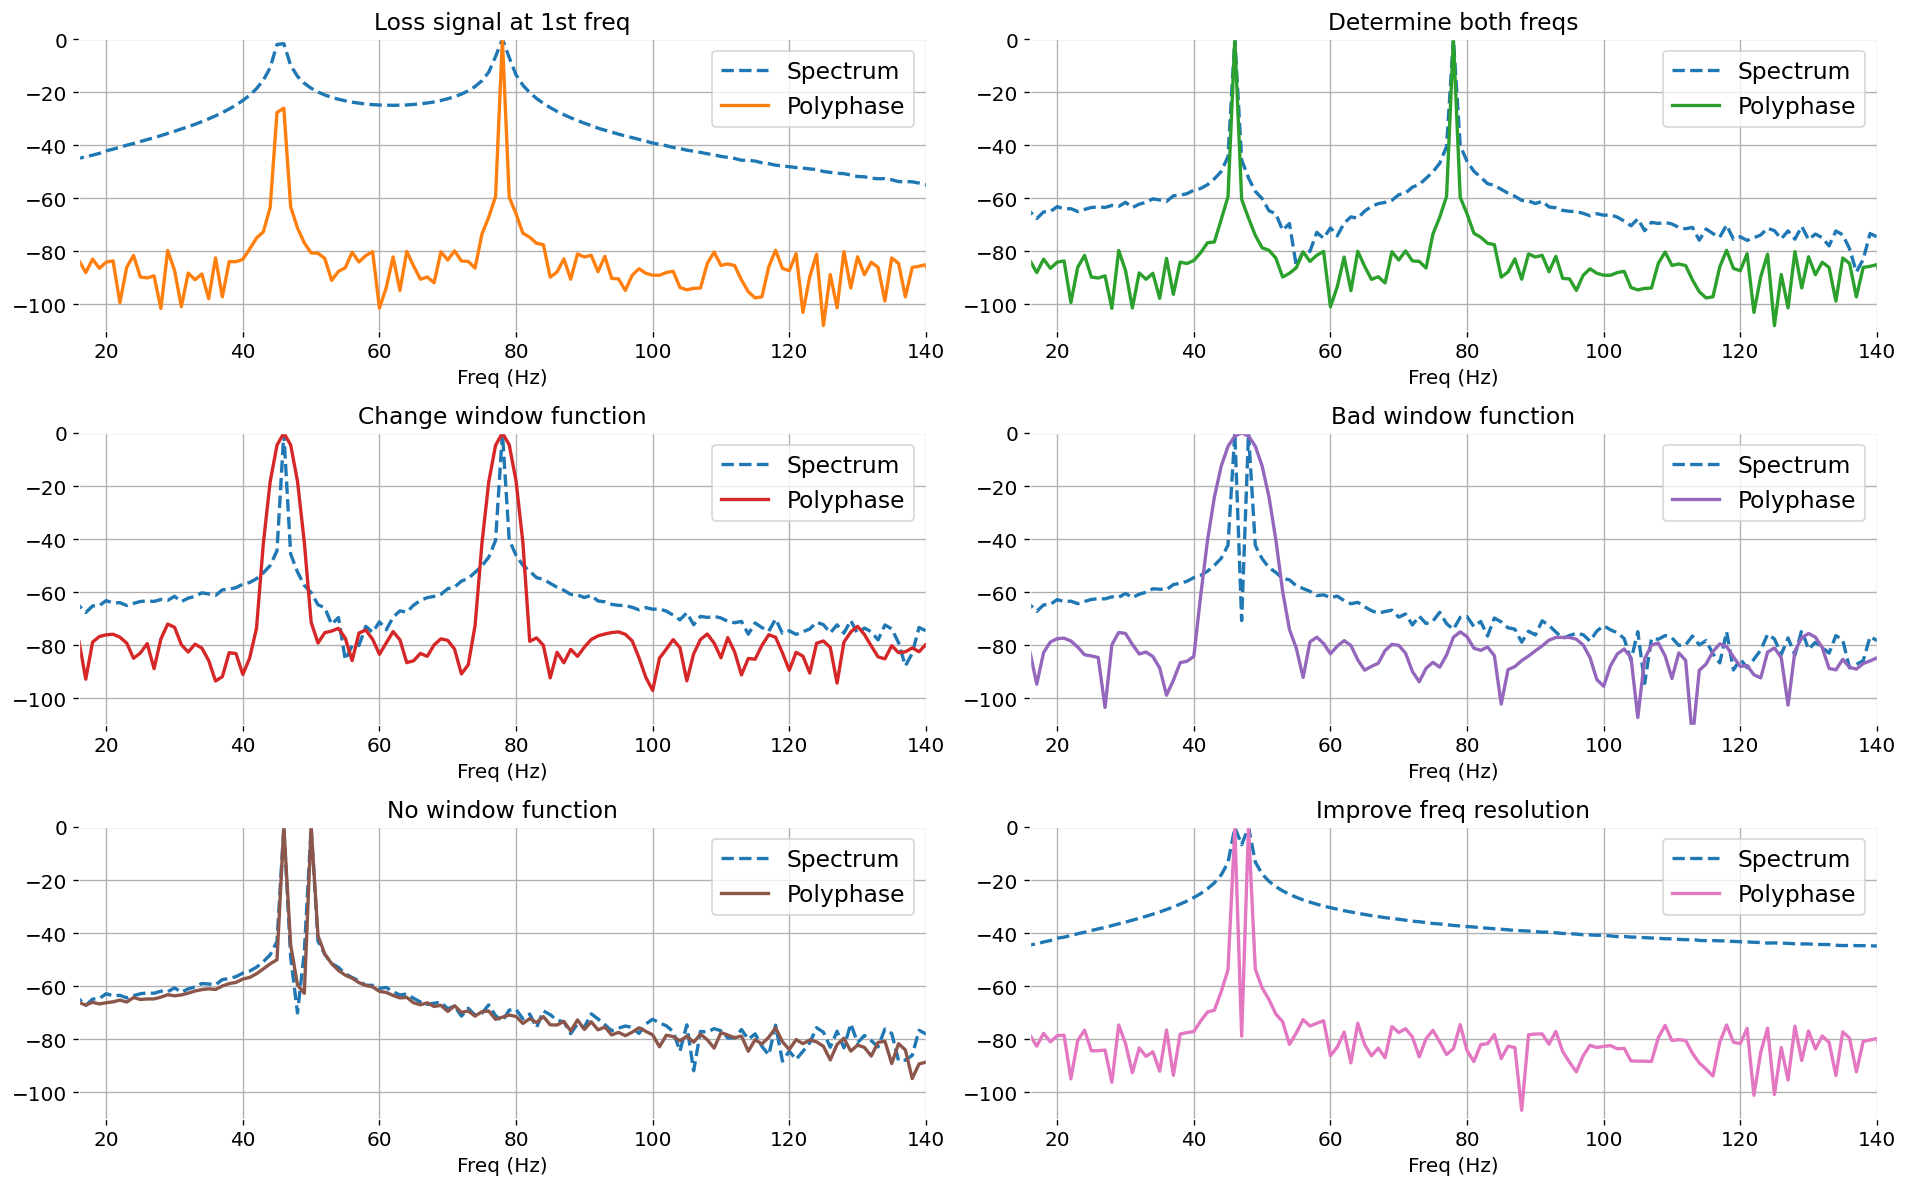

In [19]:
plt.figure(figsize=(16, 10), dpi=120)
for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.title(xs_titles[i])
    plt.plot(Xw[i], '--', linewidth=2, label='Spectrum')
    plt.plot(Xn[i], label='Polyphase', linewidth=2, color='C'+str(1+i))
    plt.xlim([16, 140])
    plt.ylim([-110, 0])
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper right')
    plt.tight_layout()

## Выводы

Физическая природа *улучшения* характеристик сигналов при их усреднении выражена в увеличении **времени наблюдения** за процессом. Чем дольше мы наблюдаем за физическим явлением, тем больше информации о нем мы можем дать. На основании этого можно сделать ряд выводов, которые помогут лучше понять возможности использования тех или иных алгоритмов усреднения сигналов.

- Использование **усреднения по частоте** позволяет получить качественное представление модуля спектра сигнала, уменьшив шумовые выбросы.
- Детерминированные сигналы не меняют своего уровня по амплитуде, а случайные шумовые компоненты сглаживаются в процессе усреднения.
- Использование **усреднения по времени** приводит к разным результатам и в общем случае должно использоваться с большой осторожностью:
    * спектр полифазного БПФ совпадает с разреженным спектром исходной (длинной) последовательности,
    * при несовпадении начальных фаз гармонических сигналов, участвующих в суммировании, происходит искажение результирующего сигнала. Это отражается на форме сигнала во временной области, а также на уровне сигнала,
    * при совпадении начальных фаз гармонических сигналов возможно получить *лучшие* показатели отношения сигнал-шум и *визуально* получить лучшую разрешающую способность,
    * для качественного использования полифазного БПФ рекомендуется использовать оконные функции с правильно подобранными параметрами, влияющими на ширину спектра сигнала.

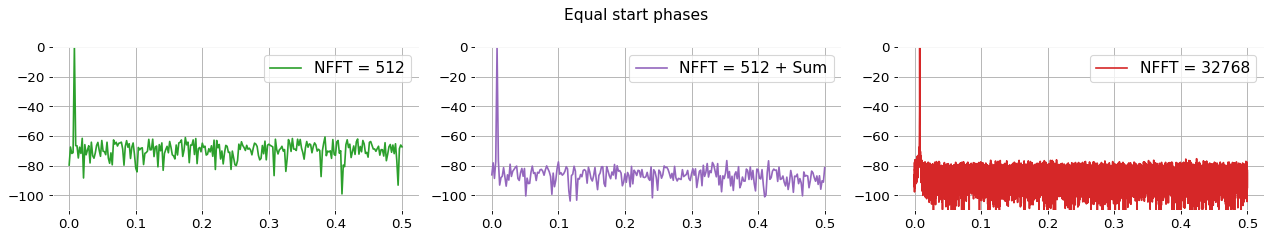

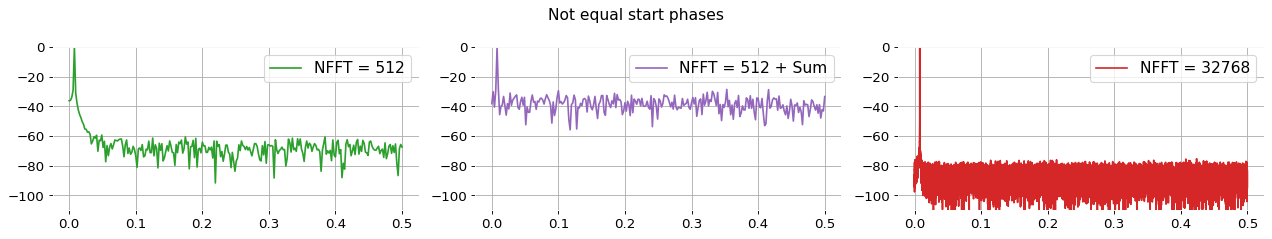

In [20]:
def signals_compare(freq=280, suptitle=''):
    N, L = 512, 64
    M = N*L

    # Input signal
    np.random.seed(42)
    x1 = np.cos(2*np.pi*freq*np.linspace(0, 1, M)) + np.random.normal(0, 5*1e-3, M)
    x2 = np.copy(x1[:N])
    x3 = x1.reshape(L, N).sum(0)
    
    # FFT - M size
    XM = np.abs(fft(x1, M))[:M//2]
    XN = np.abs(fft(x2, N))[:N//2]
    XS = np.abs(fft(x3, N))[:N//2]

    XNlog = 20*np.log10(XN / XN.max())
    XMlog = 20*np.log10(XM / XM.max())
    XSlog = 20*np.log10(XS / XS.max())
    
    fn = np.linspace(0, 0.5, N//2)
    fm = np.linspace(0, 0.5, M//2)
    
    plt.figure(figsize=(16, 3), dpi=80)
    plt.suptitle(suptitle)
    plt.subplot(1, 3, 1)
    plt.plot(fn, XNlog, color='C2', label=f'NFFT = {N}')
    plt.ylim([-110, 0])
    plt.legend(loc='upper right')
    
    plt.subplot(1, 3, 2)
    plt.plot(fn, XSlog, color='C4', label=f'NFFT = {N} + Sum')
    plt.ylim([-110, 0])
    plt.legend(loc='upper right')
    
    plt.subplot(1, 3, 3)
    plt.plot(fm, XMlog, color='C3', label=f'NFFT = {M}')
    plt.ylim([-110, 0])
    plt.legend(loc='upper right')
    plt.tight_layout()

signals_compare(freq=256, suptitle='Equal start phases')
signals_compare(freq=258, suptitle='Not equal start phases')